<a href="https://colab.research.google.com/github/pedrohortencio/machine-learning-gladiator/blob/main/Titanic/Titanic_Gladiator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing packages

In [81]:
import numpy as np                  
import pandas as pd                 
import matplotlib.pyplot as plt     
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras

from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


grid = False

seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

sns.set_theme()
%matplotlib inline

###Downloading the competition data

In [82]:
# Changing the directory of kaggle.json token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

#Downloading the dataset
!kaggle competitions download -c titanic

kaggle.json
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


###Creating dataframes

In [83]:
df_train = pd.read_csv('/content/train.csv', header=0, sep=',', 
                       quotechar='"',index_col="PassengerId")
df_test = pd.read_csv('/content/test.csv', header=0, sep=',',
                      quotechar='"', index_col="PassengerId")

In [84]:
df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [85]:
df_test.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [86]:
print("Train dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)

Train dataset shape: (891, 11)
Test dataset shape: (418, 10)


## Exploratory Data Analysis

### Searching for Missing Values

In [87]:
# Distribution in the train dataset
print("Train Dataset\n")
print(df_train.Pclass.value_counts(dropna=False))  
print("--"*15)
print(df_train.Embarked.value_counts(dropna=False))
print("--"*15)
print(df_train.SibSp.value_counts(dropna=False))
print("--"*15)
print(df_train.Parch.value_counts(dropna=False))
print("--"*15)

Train Dataset

3    491
1    216
2    184
Name: Pclass, dtype: int64
------------------------------
S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64
------------------------------
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
------------------------------
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
------------------------------


In [88]:
# Distribution in the test dataset
print("Test Dataset\n")
print(df_test.Pclass.value_counts(dropna=False))  
print("--"*15)
print(df_test.Embarked.value_counts(dropna=False))
print("--"*15)
print(df_test.SibSp.value_counts(dropna=False))
print("--"*15)
print(df_test.Parch.value_counts(dropna=False))
print("--"*15)

Test Dataset

3    218
1    107
2     93
Name: Pclass, dtype: int64
------------------------------
S    270
C    102
Q     46
Name: Embarked, dtype: int64
------------------------------
0    283
1    110
2     14
4      4
3      4
8      2
5      1
Name: SibSp, dtype: int64
------------------------------
0    324
1     52
2     33
3      3
9      2
4      2
6      1
5      1
Name: Parch, dtype: int64
------------------------------


In [89]:
# NaN values in train dataset
df_train.isnull().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
Survived      0
dtype: int64

In [90]:
# NaN values in test dataset
df_test.isnull().sum().sort_values(ascending=False)

Cabin       327
Age          86
Fare          1
Embarked      0
Ticket        0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
dtype: int64

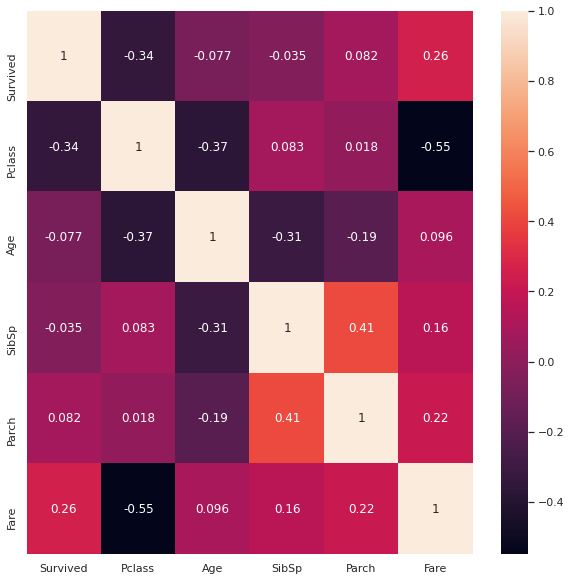

In [91]:
#Analysing the correlation of features 

mat = df_train.corr()
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(mat, annot = True, annot_kws={'size': 12});

The above plot give us some information about the correlation between the variables, some are expected and some aren't:

* High fares and ages are correlated with a higher ticket class (1st, for instance)

* High ages are correlated with lower number of of siblings / spouses aboard the Titanic

* Number of parents / children aboard the Titanic and ticket class share a weak correlation

* Age and Fare share a weak correlation

* Number of siblings / spouses aboard the Titanic and ticket class share a weak correlation

* Survival rates are more correlated with ticket class and fare

### Cabin column manipulation

In [92]:
# Survival distribution where the Cabin value is NaN
df_train[df_train['Cabin'].isnull()]['Survived'].value_counts()

0    481
1    206
Name: Survived, dtype: int64

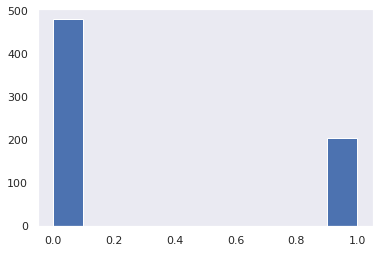

In [93]:
# Survival distribution where the Cabin value is NaN
df_train[df_train['Cabin'].isnull()]['Survived'].hist(grid=False);

In [94]:
# Survival distribution where the Cabin value isn't NaN
df_train[np.logical_not(df_train['Cabin'].isnull())]['Survived'].value_counts()

1    136
0     68
Name: Survived, dtype: int64

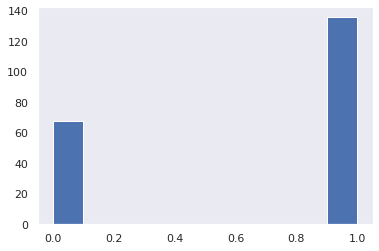

In [95]:
# Survival distribution where the Cabin value isn't NaN
df_train[np.logical_not(df_train['Cabin'].isnull())]['Survived'].hist(grid=False);

>The plots above tell us that the survival rates are higher when there's a value in the Cabin column.

In [96]:
# Creating column "CabinMissing" which will have 1 if there's a NaN value in Cabin, and 0 otherwhise 
df_train['CabinMissing'] = df_train['Cabin'].isnull().astype(int)
df_test['CabinMissing'] = df_test['Cabin'].isnull().astype(int)

In [97]:
df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0


### Name Column manipulation

Extracting Title from the Name Column

In [98]:
# Combining the two datasets for easier iteration
combined_datasets = [df_train, df_test]

In [99]:
# Loop to iterate over the 2 datasets
for dataset in combined_datasets:
    # Extracting the title
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [100]:
pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [101]:
for dataset in combined_datasets:
    # Combining less common titles under the category "Others"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Others')

    # Replacing misspelled words
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [102]:
df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Others,0.347826


In [103]:
df_train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss


In [104]:
# Mapping the titles into numeric values
title_dict_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Others": 5}
for dataset in combined_datasets:
    dataset['Title'] = dataset['Title'].map(title_dict_map)
    dataset['Title'] = dataset['Title'].fillna(0)

###Fare Column Manipulation

In [105]:
print(df_train.shape)
print(df_train["Fare"].unique().shape)

(891, 13)
(248,)


In [106]:
# Filling missing values with 0
df_train['Fare'].fillna(0, inplace=True)
df_test['Fare'].fillna(0, inplace=True)

In [107]:
df_test[df_test['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title
PassengerId,,,,,,,,,,,,


In [108]:
df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [109]:
df_train['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

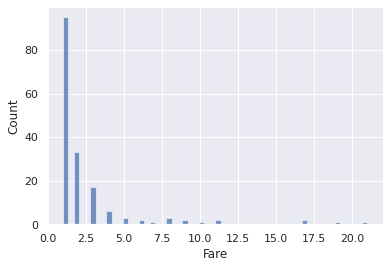

In [110]:
sns.histplot(df_test['Fare'].value_counts());

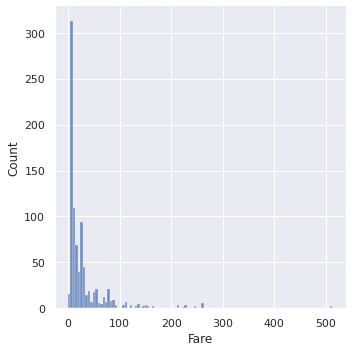

In [111]:
sns.displot(df_train['Fare']);

###Embarked Column

In [112]:
# Checking the rows that have null values in the Embarked column
df_train[df_train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title
PassengerId,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,2
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,3


In [113]:
# This will be filled with the mode (the most common value)
freq_embarked_port = df_train.Embarked.dropna().mode()[0]

for dataset in combined_datasets:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_embarked_port)

In [114]:
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [115]:
# As it seems that there's a correlation, this column will be kept. Converting to numeric:

for dataset in combined_datasets:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [116]:
df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,3


In [117]:
df_test.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,2,1,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,0,1,3


###Parch and SibSp columns

In [118]:
# I'll create a new column (FamilyMembers) to see who is alone and how that correlates to the survival rate
for dataset in combined_datasets:
    dataset['FamilyMembers'] = dataset['SibSp'] + dataset['Parch'] + 1

In [119]:
df_train[['FamilyMembers', 'Survived']].groupby(['FamilyMembers'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilyMembers,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [120]:
# Simplifying it creating a column "IsAlone"for dataset in combine:
for dataset in combined_datasets:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilyMembers'] == 1, 'IsAlone'] = 1

In [121]:
df_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


###Sex Column

In [122]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [123]:
#The correlation is strong. So I'll map into numeric values to use it in the ML algorithm
for dataset in combined_datasets:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [124]:
df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title,FamilyMembers,IsAlone
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,1,2,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,0,3,2,0


In [125]:
df_test.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title,FamilyMembers,IsAlone
PassengerId,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2,1,1,1,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0,1,3,2,0


###Filling Missing Values in Age Column

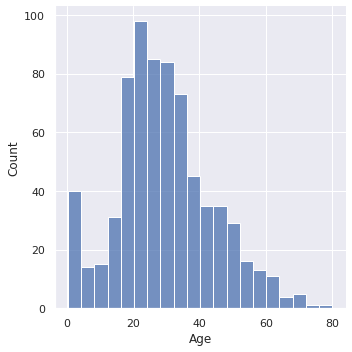

In [126]:
sns.displot(df_train['Age']);

In [127]:
df_train['Age'].fillna(-1, inplace=True)
df_test['Age'].fillna(-1, inplace=True)

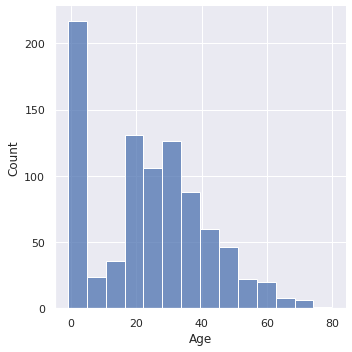

In [128]:
sns.displot(df_train['Age']);

In [129]:
df_train.isnull().sum().sort_values(ascending=False)

Cabin            687
IsAlone            0
FamilyMembers      0
Title              0
CabinMissing       0
Embarked           0
Fare               0
Ticket             0
Parch              0
SibSp              0
Age                0
Sex                0
Name               0
Pclass             0
Survived           0
dtype: int64

In [130]:
df_test.isnull().sum().sort_values(ascending=False)

Cabin            327
IsAlone            0
FamilyMembers      0
Title              0
CabinMissing       0
Embarked           0
Fare               0
Ticket             0
Parch              0
SibSp              0
Age                0
Sex                0
Name               0
Pclass             0
dtype: int64

###Analysing Correlation

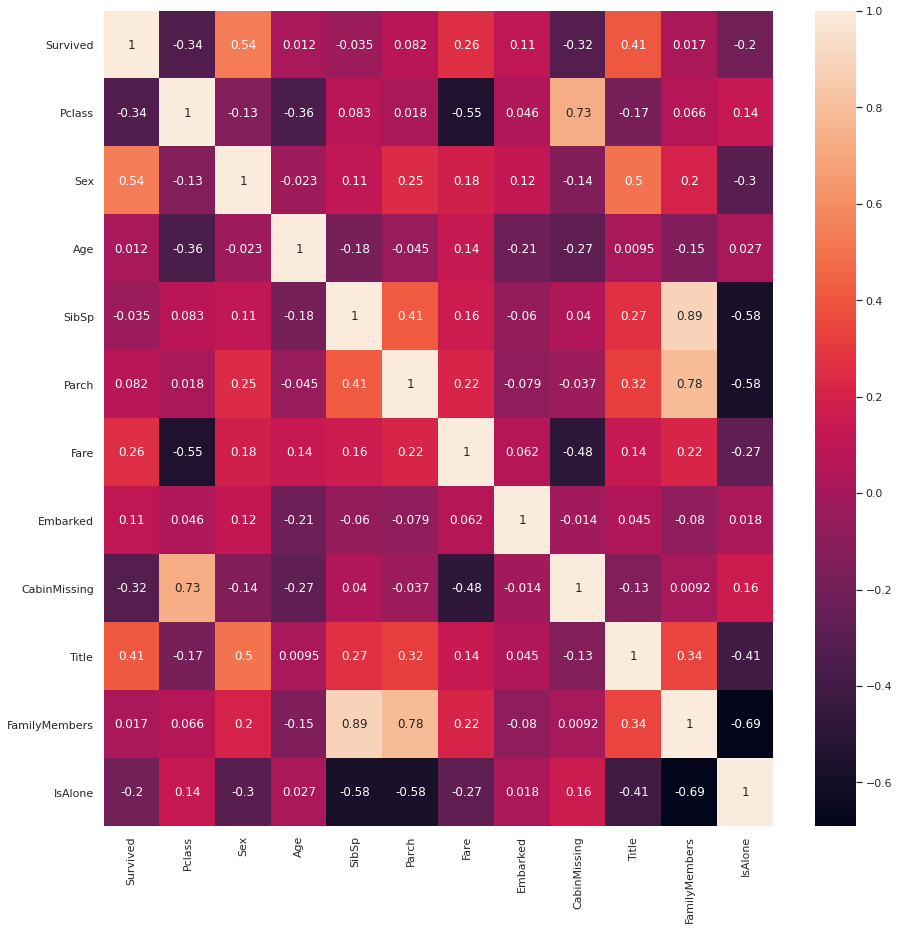

In [131]:
#Analysing the correlation of features again

mat2 = df_train.corr()
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(mat2, annot = True, annot_kws={'size': 12});

* -1: Missing
* 1: Child (0-12 years)
* 2: Adolescence (13-18 years)
* 3: Adult (19-59 years)
* 4: Senior Adult (60 years and above)

In [132]:
def age_group(value):
    if value == -1:
        return -1   # missing value
    if value >= 0 and value <= 12:
        return 1    # child 
    if value > 12 and value <= 18:
        return 2    # adolescent
    if value > 18 and value <= 59:
        return 3    # adult
    if value > 59:
        return 4    # senior

In [133]:
df_train['Age Group'] = df_train['Age'].map(age_group)
df_test['Age Group'] = df_test['Age'].map(age_group)

In [134]:
df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinMissing,Title,FamilyMembers,IsAlone,Age Group
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,1,2,0,3
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,0,3,2,0,3


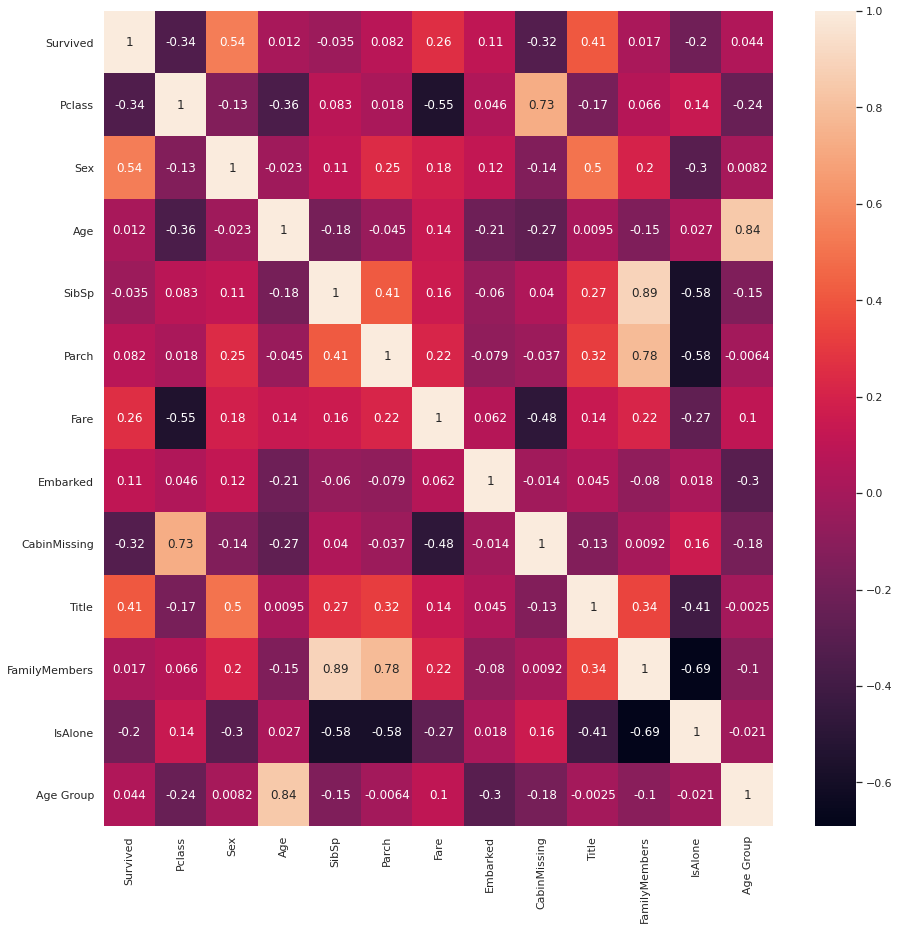

In [135]:
#Analysing the correlation of features again

mat2 = df_train.corr()
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(mat2, annot = True, annot_kws={'size': 12});

###Dropping columns

In [136]:
columns_to_drop = ['FamilyMembers', 'Ticket', 'Parch', 'SibSp', 'Name', 'Cabin']

In [137]:
for dataset in combined_datasets:
    dataset.drop(columns=columns_to_drop, inplace=True)

In [138]:
df_train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,CabinMissing,Title,IsAlone,Age Group
PassengerId,,,,,,,,,,
1,0,3,0,22.0,7.2500,0,1,1,0,3
2,1,1,1,38.0,71.2833,1,0,3,0,3


In [139]:
df_test.head(2)

,Pclass,Sex,Age,Fare,Embarked,CabinMissing,Title,IsAlone,Age Group
PassengerId,,,,,,,,,
892,3,0,34.5,7.8292,2,1,1,1,3
893,3,1,47.0,7.0000,0,1,3,0,3


###Creating dataframes with normalized values

In [140]:
df_train.mean()

Survived         0.383838
Pclass           2.308642
Sex              0.352413
Age             23.600640
Fare            32.204208
Embarked         0.361392
CabinMissing     0.771044
Title            1.728395
IsAlone          0.602694
Age Group        2.001122
dtype: float64

In [141]:
def normalize_df(df_train, df_test):
    df_train_norm = df_train.copy()
    df_test_norm = df_test.copy()

    ### Min-Max Scale
    """min = df_train.min()
    max = df_train.max()

    df_train_norm = (df_train - min) / (max - min)
    df_test_norm = (df_test - min.drop("Survived")) / (max.drop("Survived") - min.drop("Survived"))"""

    ### Normalization
    mean = df_train.mean()
    std = df_train.std()

    df_train_norm = (df_train - mean) / (df_train - std)
    df_test_norm = (df_test - mean.drop("Survived")) / (df_test - std.drop("Survived"))


    return df_train_norm, df_test_norm

In [142]:
df_train_norm, df_test_norm = normalize_df(df_train, df_test)

In [143]:
df_train_norm.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,CabinMissing,Title,IsAlone,Age Group
PassengerId,,,,,,,,,,
1,0.788829,0.319492,0.737281,-0.387329,0.587940,0.568518,0.395022,24.248708,1.230954,0.720067
2,1.200141,-7.982992,1.240564,0.715229,1.810066,1.752846,1.834085,0.645497,1.230954,0.720067


In [144]:
df_test_norm.head(2)

,Pclass,Sex,Age,Fare,Embarked,CabinMissing,Title,IsAlone,Age Group
PassengerId,,,,,,,,,
892,0.319492,0.737281,0.655305,0.582240,1.201038,0.395022,24.248708,0.778445,0.720067
893,0.319492,1.240564,0.803205,0.590353,0.568518,0.395022,0.645497,1.230954,0.720067


In [145]:
df_train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,CabinMissing,Title,IsAlone,Age Group
PassengerId,,,,,,,,,,
1,0,3,0,22.0,7.2500,0,1,1,0,3
2,1,1,1,38.0,71.2833,1,0,3,0,3


In [146]:
df_test.head(2)

,Pclass,Sex,Age,Fare,Embarked,CabinMissing,Title,IsAlone,Age Group
PassengerId,,,,,,,,,
892,3,0,34.5,7.8292,2,1,1,1,3
893,3,1,47.0,7.0000,0,1,3,0,3


###Splitting the data

In [147]:
# Creating the ndarrays from the training dataset
y = df_train['Survived'].to_numpy()
X = df_train.drop('Survived', axis=1).to_numpy()

X_norm = df_train_norm.drop('Survived', axis=1).to_numpy()

In [148]:
# Creating the train and validation datasets
(X_train, X_validation, 
 y_train, y_validation) = train_test_split(X, y, test_size = 0.2, random_state=0)

(X_train_norm, X_validation_norm, 
 y_train_norm, y_validation_norm) = train_test_split(X_norm, y, test_size = 0.2, random_state=0)

In [149]:
print('Non normalized datasets')
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print()
print('Normalized datasets')
print('Train', X_train_norm.shape)
print('Validation', X_validation_norm.shape)

Non normalized datasets
(712, 9)
(712,)
(179, 9)
(179,)

Normalized datasets
Train (712, 9)
Validation (179, 9)


## Creating Models
(with the non-normalized dataset)

In [150]:
# 5 layers with dropout and regularization (both L1 and L2)
def create_model():
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation=tf.nn.relu),

                                        tf.keras.layers.Dense(64, activation=tf.nn.relu),

                                        tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                        
                                        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
    model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [151]:
# Function that creates and trains all models. It will make it easier to train twice (with non-normalized and normalized data)

def train_models(X_train, y_train, X_validation, y_validation, print_acc=False):

    dict_acc = {}

    ### Dummy Classifier
    dummy = DummyClassifier(strategy='prior')
    
    scores = cross_val_score(dummy, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_dummy_train = scores.mean()
    dummy.fit(X_train, y_train)
    acc_dummy_val = dummy.score(X_validation, y_validation)

    dict_acc['Dummy Classifier'] = [acc_dummy_train, acc_dummy_val]


    ### Bernoulli Naive Bayes
    bernoulli = BernoulliNB(alpha=15)

    scores = cross_val_score(bernoulli, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_bernoulli_train = scores.mean()
    bernoulli.fit(X_train, y_train)
    acc_bernoulli_val = bernoulli.score(X_validation, y_validation)

    dict_acc['Bernoulli NB'] = [acc_bernoulli_train, acc_bernoulli_val]


    ### K-Nearest Neighbors
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors = 5, weights='uniform')


    scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_knn_train = scores.mean()
    knn.fit(X_train, y_train)
    acc_knn_val = knn.score(X_validation, y_validation)

    dict_acc['KNN'] = [acc_knn_train, acc_knn_val]


    ### SGD Classifier
    sgd = SGDClassifier(alpha=0.01, epsilon = 0.1, loss='hinge', max_iter=5000, penalty='l1')

    scores = cross_val_score(sgd, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_sgd_train = scores.mean()
    sgd.fit(X_train, y_train)
    acc_sgd_val = sgd.score(X_validation, y_validation)

    dict_acc['SGD'] = [acc_sgd_train, acc_sgd_val]


    ### Logistic Regression
    logreg = LogisticRegression(C=0.5, max_iter = 2000, solver='liblinear')

    scores = cross_val_score(logreg, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_logreg_train = scores.mean()
    logreg.fit(X_train, y_train)
    acc_logreg_val = logreg.score(X_validation, y_validation)

    dict_acc['Logistic Regression'] = [acc_logreg_train, acc_logreg_val]


    ### Ridge Classifier
    ridge = RidgeClassifier(alpha=5)

    scores = cross_val_score(ridge, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_ridge_train = scores.mean()
    ridge.fit(X_train, y_train)
    acc_ridge_val = ridge.score(X_validation, y_validation)
    
    dict_acc['Ridge Classifier'] = [acc_ridge_train, acc_ridge_val]


    ### Support Vector Classifier
    svc = SVC(kernel='linear', C=0.5)

    scores = cross_val_score(svc, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_svc_train = scores.mean()
    svc.fit(X_train, y_train)
    acc_svc_val = svc.score(X_validation, y_validation)

    dict_acc['SVC'] = [acc_svc_train, acc_svc_val]


    ### Decision Tree
    tree = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=2)

    scores = cross_val_score(tree, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_tree_train = scores.mean()
    tree.fit(X_train, y_train)
    acc_tree_val = tree.score(X_validation, y_validation)

    dict_acc['Decision Tree'] = [acc_tree_train, acc_tree_val]


    ### Random Forest
    rf = RandomForestClassifier(n_estimators=300, criterion='gini', min_samples_leaf=3, min_samples_split=2)

    scores = cross_val_score(rf, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_rf_train = scores.mean()
    rf.fit(X_train, y_train)
    acc_rf_val = rf.score(X_validation, y_validation)

    dict_acc['Random Forest'] = [acc_rf_train, acc_rf_val]


    ### XGBoost Classifier
    xgboost = XGBClassifier(eta=0.1, max_depth=4)

    scores = cross_val_score(xgboost, X_train, y_train, cv=kfold, scoring='accuracy')
    acc_xgboost_train = scores.mean()
    xgboost.fit(X_train, y_train)
    acc_xgboost_val = xgboost.score(X_validation, y_validation)

    dict_acc['XGBoost'] = [acc_xgboost_train, acc_xgboost_val]


    ### Neural Network (Keras)
    model_keras = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)

    results = cross_val_score(model_keras, X_train, y_train, cv=kfold)
    acc_train = results.mean()
    model_keras.fit(X_train, y_train)
    acc_keras = model_keras.score(X_validation, y_validation)

    dict_acc['DNN'] = [acc_train, acc_keras] 

    # Printing the values
    if print_acc:
        for key, values in dict_acc.items():
            print("{} Accuracy on Training Data (CV): {}".format(key, values[0]))
            print("{} Accuracy on Validation Data: {}".format(key, values[1]))
            print()
    
    return dict_acc

## Grid Search

In [152]:
if grid:
    ###Naive Bayes (Bernoulli)
    parameter = [{'alpha':[1.0, 5, 10, 15, 20]}]
    classifier = GridSearchCV(BernoulliNB(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Bernoulli")
    print(classifier.best_params_)
    print(classifier.best_score_)

    ###KNN
    parameter = [{'n_neighbors':[2, 3, 5, 7, 10],
                'weights':['uniform', 'distance'],
                'metric':['minkowski', 'manhattan']}]

    classifier = GridSearchCV(KNeighborsClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("KNN")
    print(classifier.best_params_)
    print(classifier.best_score_)

    ###SGD
    parameter = [{'loss':['hinge', 'modified_huber', 'perceptron', 'huber', 'epsilon_insensitive'],
                'penalty':['l1', 'l2'],
                'alpha':[0.001, 0.01, 0.1],
                'epsilon':[0.01, 0.1, 0.3, 0.5],
                'max_iter':[5000]}]

    classifier = GridSearchCV(SGDClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("SGD")
    print(classifier.best_params_)
    print(classifier.best_score_)

    ###Logistic Regression
    parameter = [{'penalty':['l1', 'l2'],
                'C':[1.0, 0.5, 1.5, 2, 3, 5],
                'solver':['lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter':[2000]}]

    classifier = GridSearchCV(LogisticRegression(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Logistic Regression")
    print(classifier.best_params_)
    print(classifier.best_score_)
    #{'C': 0.5, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


    ###Ridge Classifier
    parameter = [{'alpha':[1.0, 0.5, 3, 5, 7, 10],
                'solver':['auto', 'sag', 'saga', 'svd']}]

    classifier = GridSearchCV(RidgeClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Ridge Classifier")
    print(classifier.best_params_)
    print(classifier.best_score_)


    ###SVC
    parameter = [{'C':[0.5, 1.0, 3, 5],
                'kernel':['linear', 'rbf']}]

    classifier = GridSearchCV(SVC(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("SVC")
    print(classifier.best_params_)
    print(classifier.best_score_)

    ###Decision Tree
    parameter = [{'criterion':['gini', 'entropy'],
                'min_samples_split':[2, 3, 4, 5],
                'min_samples_leaf':[1, 4, 5]}]

    classifier = GridSearchCV(DecisionTreeClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Decision Tree")
    print(classifier.best_params_)
    print(classifier.best_score_)

    ###Random Forest
    parameter = [{'criterion':['gini', 'entropy'],
              'n_estimators':[100, 300],
              'min_samples_split':[3, 4, 5],
              'min_samples_leaf':[3, 5, 10]}]

    classifier = GridSearchCV(RandomForestClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("Random Forest")
    print(classifier.best_params_)
    print(classifier.best_score_)

    ###XGBoost
    parameter = [{'eta':[0.1, 0.3, 0.5, 1],
                'max_depth':[4, 6, 8, 10]}]

    classifier = GridSearchCV(XGBClassifier(), parameter, scoring='accuracy')
    classifier.fit(X_train, y_train)
    print("XGBoost")
    print(classifier.best_params_)
    print(classifier.best_score_)

##Plotting

In [153]:
dict_models = train_models(X_train, y_train, X_validation, y_validation, print_acc=True)

Dummy Classifier Accuracy on Training Data (CV): 0.6165763813651137
Dummy Classifier Accuracy on Validation Data: 0.6145251396648045

Bernoulli NB Accuracy on Training Data (CV): 0.7725499852260416
Bernoulli NB Accuracy on Validation Data: 0.7988826815642458

KNN Accuracy on Training Data (CV): 0.7415542204274599
KNN Accuracy on Validation Data: 0.7653631284916201

SGD Accuracy on Training Data (CV): 0.7894612429823697
SGD Accuracy on Validation Data: 0.7932960893854749

Logistic Regression Accuracy on Training Data (CV): 0.7964247020585049
Logistic Regression Accuracy on Validation Data: 0.8100558659217877

Ridge Classifier Accuracy on Training Data (CV): 0.8006599034768049
Ridge Classifier Accuracy on Validation Data: 0.770949720670391

SVC Accuracy on Training Data (CV): 0.7795922387471683
SVC Accuracy on Validation Data: 0.7877094972067039

Decision Tree Accuracy on Training Data (CV): 0.7992317541613316
Decision Tree Accuracy on Validation Data: 0.8268156424581006

Random Forest A

In [154]:
df_acc = pd.DataFrame.from_dict(dict_models)
df_acc = df_acc.transpose()
df_acc.columns = ['Acc Training (CV)', 'Acc Validation']
df_acc

,Acc Training (CV),Acc Validation
Dummy Classifier,0.616576,0.614525
Bernoulli NB,0.772550,0.798883
KNN,0.741554,0.765363
SGD,0.789461,0.793296
Logistic Regression,0.796425,0.810056
Ridge Classifier,0.800660,0.770950
SVC,0.779592,0.787709
Decision Tree,0.799232,0.826816
Random Forest,0.823097,0.826816
XGBoost,0.817463,0.860335


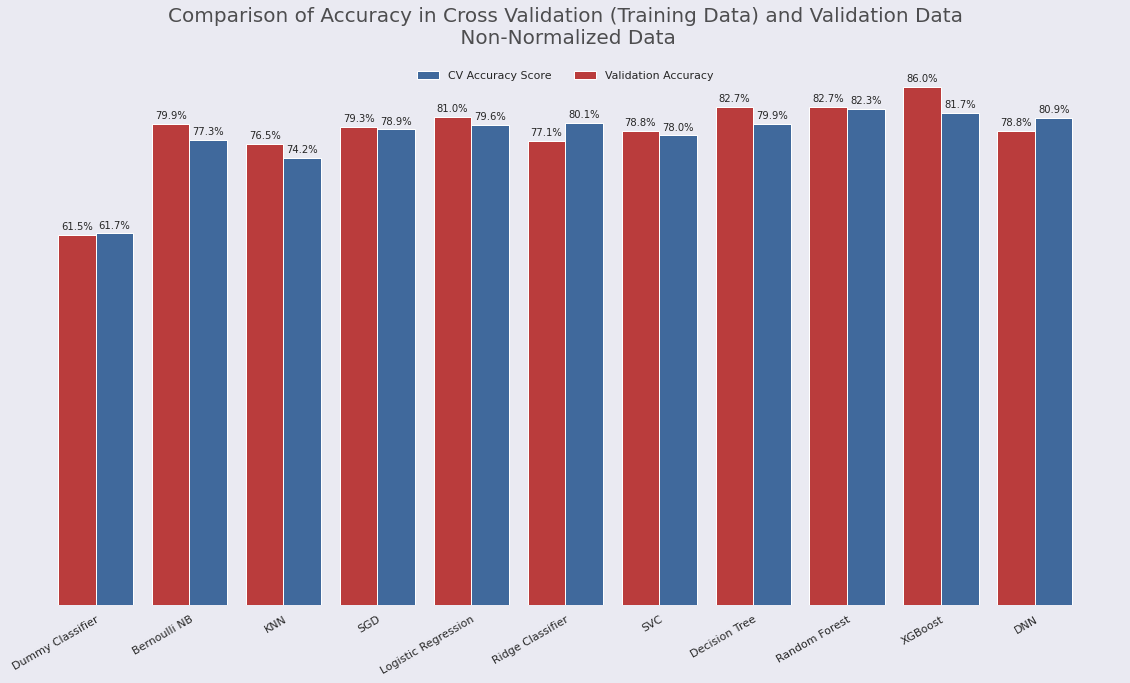

In [162]:
fig = plt.figure(figsize=(20,10))   # changes the size of the image
fig.patch.set_facecolor('#eaeaf2')  # set the background color of the plot to match the seaborn theme

ax = plt.gca()
width = 0.40

rects1 = ax.bar(df_acc.index, df_acc['Acc Training (CV)'], width,align='edge', color = '#40699c', label='CV Accuracy Score')
rects2 = ax.bar(df_acc.index, df_acc['Acc Validation'], -width, align='edge', color = '#ba3c3c', label='Validation Accuracy')

for r1, r2 in zip(rects1.patches, rects2.patches):
    h1 = r1.get_height()
    h2 = r2.get_height()

    percent1 = h1*100
    percent2 = h2*100

    ax.annotate('{:.1f}%'.format(percent1),
                    xy=(r1.get_x() + r1.get_width() / 2, h1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{:.1f}%'.format(percent2),
                    xy=(r2.get_x() + r2.get_width() / 2, h2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Rotate the X labels (models' names)

plt.box(False)  # disable the box around the plot
ax.grid(False)  # disable the grid
ax.set_yticks([])   # disable the y ticks
plt.xticks(rotation=30, rotation_mode="anchor", ha='right')

# creating a title
plt.title('Comparison of Accuracy in Cross Validation (Training Data) and Validation Data\n Non-Normalized Data',
          size=20, alpha=0.8, y=1.02)

# add the legend (to display the horizontal lines' labels)
plt.legend(frameon=False, loc='upper center', ncol=2)

# saves the plot
plt.savefig("accuracy-nonnormalized.png", bbox_inches='tight', dpi=300)
# displays the plot
plt.show();

###Normalized Data

In [156]:
dict_models_norm = train_models(X_train_norm, y_train_norm, X_validation_norm, y_validation_norm)

In [157]:
df_acc_norm = pd.DataFrame.from_dict(dict_models_norm)
df_acc_norm = df_acc_norm.transpose()
df_acc_norm.columns = ['Acc Training (CV)', 'Acc Validation']
df_acc_norm

,Acc Training (CV),Acc Validation
Dummy Classifier,0.616576,0.614525
Bernoulli NB,0.619364,0.692737
KNN,0.810450,0.793296
SGD,0.645395,0.743017
Logistic Regression,0.785236,0.759777
Ridge Classifier,0.783847,0.759777
SVC,0.789451,0.754190
Decision Tree,0.799202,0.826816
Random Forest,0.825894,0.843575
XGBoost,0.816074,0.849162


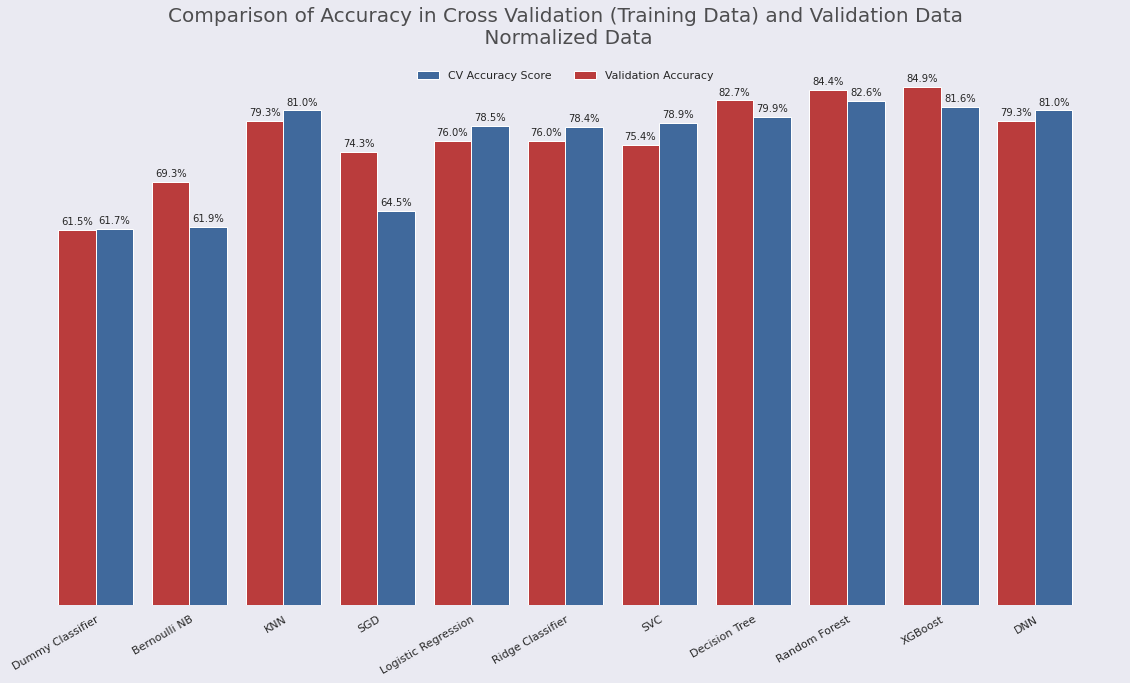

In [161]:
fig = plt.figure(figsize=(20,10))   # changes the size of the image
fig.patch.set_facecolor('#eaeaf2')  # set the background color of the plot to match the seaborn theme

ax = plt.gca()
width = 0.40

rects1 = ax.bar(df_acc_norm.index, df_acc_norm['Acc Training (CV)'], width,align='edge', color = '#40699c', label='CV Accuracy Score')
rects2 = ax.bar(df_acc_norm.index, df_acc_norm['Acc Validation'], -width, align='edge', color = '#ba3c3c', label='Validation Accuracy')

for r1, r2 in zip(rects1.patches, rects2.patches):
    h1 = r1.get_height()
    h2 = r2.get_height()

    percent1 = h1*100
    percent2 = h2*100

    ax.annotate('{:.1f}%'.format(percent1),
                    xy=(r1.get_x() + r1.get_width() / 2, h1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{:.1f}%'.format(percent2),
                    xy=(r2.get_x() + r2.get_width() / 2, h2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Rotate the X labels (models' names)

plt.box(False)  # disable the box around the plot
ax.grid(False)  # disable the grid
ax.set_yticks([])   # disable the y ticks
plt.xticks(rotation=30, rotation_mode="anchor", ha='right')

# creating a title
plt.title('Comparison of Accuracy in Cross Validation (Training Data) and Validation Data\n Normalized Data',
          size=20, alpha=0.8, y=1.02)

# add the legend (to display the horizontal lines' labels)
plt.legend(frameon=False, loc='upper center', ncol=2)

# saves the plot
plt.savefig("accuracy-normalized.png", bbox_inches='tight', dpi=300)
# displays the plot
plt.show();

### Comparison Between Normalized and Non-Normalized Accuracy

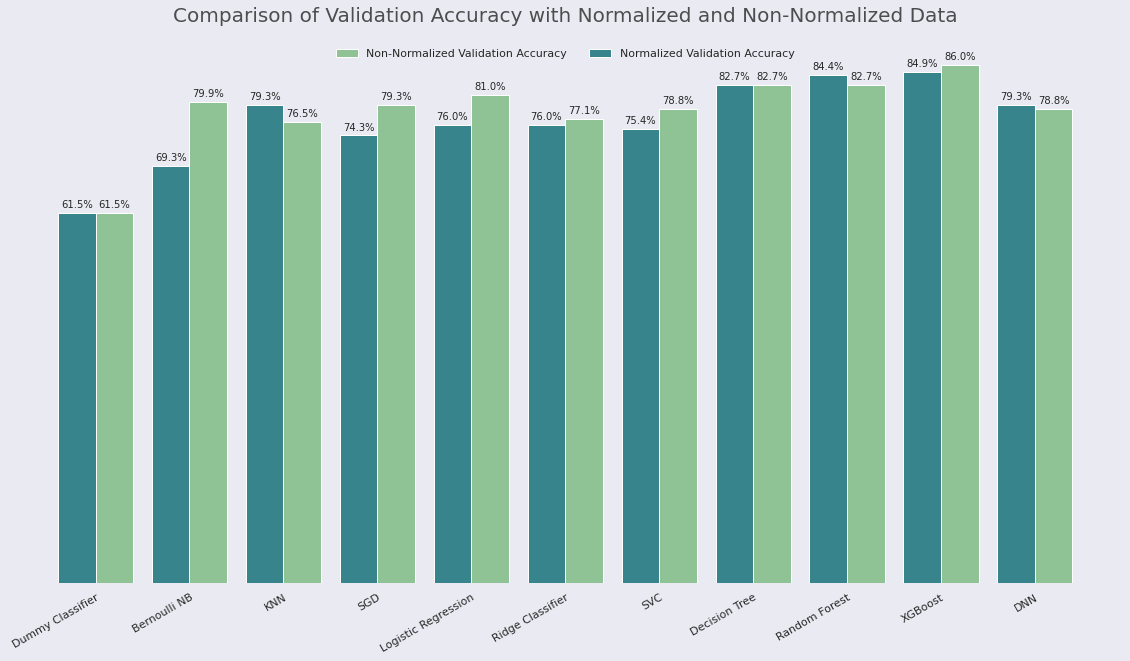

In [160]:
fig = plt.figure(figsize=(20,10))   # changes the size of the image
fig.patch.set_facecolor('#eaeaf2')  # set the background color of the plot to match the seaborn theme

ax = plt.gca()
width = 0.40

rects1 = ax.bar(df_acc.index, df_acc['Acc Validation'], width,align='edge', color = '#8FC294', label='Non-Normalized Validation Accuracy')
rects2 = ax.bar(df_acc_norm.index, df_acc_norm['Acc Validation'], -width, align='edge', color = '#37848C', label='Normalized Validation Accuracy')

for r1, r2 in zip(rects1.patches, rects2.patches):
    h1 = r1.get_height()
    h2 = r2.get_height()

    percent1 = h1*100
    percent2 = h2*100

    ax.annotate('{:.1f}%'.format(percent1),
                    xy=(r1.get_x() + r1.get_width() / 2, h1),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{:.1f}%'.format(percent2),
                    xy=(r2.get_x() + r2.get_width() / 2, h2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Rotate the X labels (models' names)

plt.box(False)  # disable the box around the plot
ax.grid(False)  # disable the grid
ax.set_yticks([])   # disable the y ticks
plt.xticks(rotation=30, rotation_mode="anchor", ha='right')

# creating a title
plt.title('Comparison of Validation Accuracy with Normalized and Non-Normalized Data',
          size=20, alpha=0.8, y=1.02)

# add the legend (to display the horizontal lines' labels)
plt.legend(frameon=False, loc='upper center', ncol=2)

# saves the plot
plt.savefig("comparison-normalized-nonnormalized.png", bbox_inches='tight', dpi=300)
# displays the plot
plt.show();